***PART 1***

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
from time import time
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import TomekLinks
from multiprocessing import Process
from time import time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
#Loading the data and removing unwanted columns specified below
df = pd.read_csv('weatherAUS.csv')
df = df.drop(df.columns[0],axis = 1)#Dropping the Dates
df =df.drop(df.columns[-2], axis = 1)#Dropping the RISK_MM column
#Any features with more than 30% of empty data are removed
limitPer = len(df) * .7
df_2 = df.dropna(thresh=limitPer,axis=1)
data = df_2.copy()

In [3]:
#Performing imputation on missing values
#Using Median values to fill up missing numerical features - to avoid taking mean consisting of outliers
imp1 = SimpleImputer(strategy="median")
df_knn_imputed_float_columns = imp1.fit_transform(df_2[df_2.columns[df_2.dtypes=='float64']])
df_knn_imputed_float_columns = pd.DataFrame(df_knn_imputed_float_columns,columns = list(data.columns[data.dtypes=='float64']))

#Using most frequent values to fill up missing categorical features - to keep the process simple at this point
imp2 = SimpleImputer(strategy="most_frequent")
df_knn_imputed_categorical_columns = imp2.fit_transform(df[df.columns[df.dtypes!='float64']])
df_knn_imputed_categorical_columns = pd.DataFrame(df_knn_imputed_categorical_columns,columns = list(data.columns[data.dtypes!='float64']))

#Combining and arranging the above 2 numerical and categorical dataframes into 1
df_new = pd.concat([df_knn_imputed_float_columns, df_knn_imputed_categorical_columns], axis=1, sort=False)
df_new = df_new[data.columns]

#Converting each column's data type into the most appropriate one
df_new = df_new.convert_dtypes()

In [4]:
%%time
#Label Encoding each of the categorical types
df_encoded = df_new
encoding_info = {}#stores the individual column's transformational models so that it can be inversed later
le = preprocessing.LabelEncoder()
#Label Encoding all Categorical Features
for i in df_encoded.columns[df_encoded.dtypes=='string']:
    df_encoded[i] = le.fit_transform(df_encoded[i])
    encoding_info[i]=le

CPU times: user 118 ms, sys: 115 µs, total: 118 ms
Wall time: 117 ms


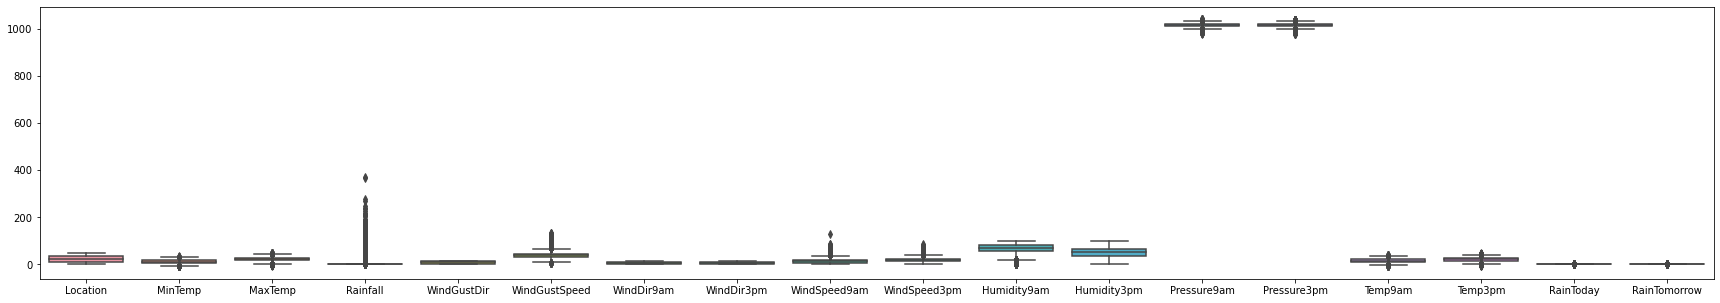

In [5]:
#Box Plotting to check outliers
#Please note that each feature was checked individually and outliers were found
#It is zoomed out for presentation purposes
plt.figure(figsize=(30,5))
sns.boxplot(data= df_encoded[df_encoded.columns])
plt.show()

In [6]:
%%time
df_outlied = df_encoded
X = df_outlied
#Performing Isolation Forest algorithm for 2% outlier elimination
clf = IsolationForest(contamination = 0.02)
clf.fit(X)
results = clf.predict(X)
outliers = X[results == -1]
normal = X[results == 1]
df_outlied = pd.DataFrame(normal,columns = list(df_outlied.columns))

CPU times: user 10.4 s, sys: 34.7 ms, total: 10.5 s
Wall time: 10.5 s


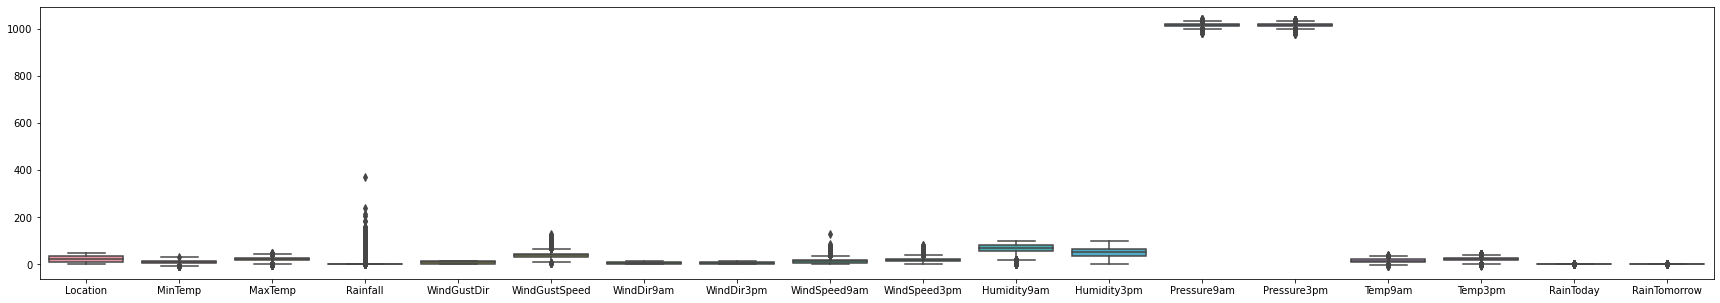

In [7]:
#Rechecking for outliers
plt.figure(figsize=(30,5))
sns.boxplot(data= df_outlied[df_outlied.columns])
plt.show()

In [8]:
#Splitting the data for training and testing
X,y = df_outlied.iloc[:,:-1], df_outlied.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
%%time
#Performing Min Max scaling of the data which rescales inbetween 0 and 1
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

CPU times: user 83.1 ms, sys: 28.1 ms, total: 111 ms
Wall time: 110 ms


In [10]:
%%time
#Checking the imbalance ratio of 0
imbalance = y[y==0].count()
print("Imbalance ratio '0':all is",imbalance[0]/y.count()[0])

#Handling imbalance using undersampling - Tomek Links
tl = TomekLinks(n_jobs=-1)
X_res, y_res = tl.fit_resample(X_train, y_train)
print("Before Tomek Sampling:",y_train.value_counts(),'\n\n')
print("After Tomek Sampling:",y_res.value_counts(),'\n\n')

Imbalance ratio '0':all is 0.7846988496508766
Before Tomek Sampling: RainTomorrow
0               87501
1               23978
dtype: int64 


After Tomek Sampling: RainTomorrow
0               82939
1               23978
dtype: int64 


CPU times: user 2min 30s, sys: 265 ms, total: 2min 30s
Wall time: 20.6 s


In [20]:
%%time
#Testing out the following ML algorithms in names variable to get a baseline
X_train,y_train = np.array(X_res),np.array(y_res).reshape(-1,)
X_test,y_test = np.array(X_test),np.array(y_test).reshape(-1,)
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel='linear'),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

def f(name,clf):
    start = time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(classification_report(y_test, y_pred))
    confusionmatrix = confusion_matrix(y_test,y_pred)
    print("Elapsed time:",time()-start)
    print(confusionmatrix,name,score,'\n')

try:
    processes = []
    for name, clf in zip(names, classifiers):
            p = Process(target = f, args =(name,clf))
            processes.append(p)
            p.start()
    for p in processes:
        p.join()
except KeyboardInterrupt:
    for p in processes:
        p.terminate()

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     21846
           1       0.53      0.54      0.54      6024

    accuracy                           0.80     27870
   macro avg       0.70      0.70      0.70     27870
weighted avg       0.80      0.80      0.80     27870

Elapsed time: 0.2759127616882324
[[19031  2815]
 [ 2786  3238]] Naive Bayes 0.7990312163616792 

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     21846
           1       0.59      0.53      0.56      6024

    accuracy                           0.82     27870
   macro avg       0.73      0.71      0.72     27870
weighted avg       0.81      0.82      0.82     27870

Elapsed time: 0.8079788684844971
[[19657  2189]
 [ 2839  3185]] QDA 0.8195909580193756 



/home/srinivas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21846
           1       0.69      0.48      0.57      6024

    accuracy                           0.84     27870
   macro avg       0.78      0.71      0.73     27870
weighted avg       0.83      0.84      0.83     27870

Elapsed time: 2.993070363998413
[[20543  1303]
 [ 3128  2896]] Logistic Regression 0.8410118406889128 

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     21846
           1       0.49      0.52      0.51      6024

    accuracy                           0.78     27870
   macro avg       0.68      0.69      0.68     27870
weighted avg       0.78      0.78      0.78     27870

Elapsed time: 3.8424761295318604
[[18548  3298]
 [ 2864  3160]] Decision Tree 0.7789020452099031 

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21846
           1       0.70      0.48 

In [12]:
'''
From the above we infer that Logistic regression, AdaBoost and QDA perform comparitively well with a
balance of performance - accuracy & classifying minority class well with respectable elapsed times
which corresponds to lower computational costs.

Henceforth the above 3 models are being chosen as the best 3 models.
'''

'\nFrom the above we infer that Logistic regression, AdaBoost and QDA perform comparitively well with a\nbalance of perfformance - accuracy & classifying minority class well with respectable elapsed times\nwhich corresponds to lower computational costs.\n\nHenceforth the above 3 models are being chosen as the best 3 models.\n'

In [13]:
%%time

#Tuning the AdaBoost Model using GridSearchCV

model = AdaBoostClassifier()

# define the grid of hyperparameters to try out all possible combinations and permutations
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the grid search procedure
grid_search = GridSearchCV(estimator=model,cv=5, param_grid=grid, n_jobs=-1)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# View best score and Hyperparameters
print("AB Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
ABC_best_params = grid_result.best_params_

AB Best: 0.850333 using {'learning_rate': 1.0, 'n_estimators': 500}
CPU times: user 49.1 s, sys: 313 ms, total: 49.4 s
Wall time: 7min 59s


In [14]:
%%time
#LOGISTIC REGRESSION HYPERPARAMETER TUNING using GridSearchCV
#Higher number of n_iter was tried with LR, but didn't result in a big difference, so the default was chosen
logistic = LogisticRegression()
# define the grid of hyperparameters to try out all possible combinations and permutations
grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
# Create grid search using 5-fold cross validation
grid_search = GridSearchCV(estimator = logistic, param_grid = grid, cv=5, n_jobs=-1)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# View best score and Hyperparameters
print("LR Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
LR_best_params = grid_result.best_params_

LR Best: 0.842308 using {'C': 10, 'penalty': 'l2'}
CPU times: user 10.6 s, sys: 8.89 s, total: 19.5 s
Wall time: 9.76 s


/home/srinivas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
%%time
#QDA HYPERPARAMETER TUNING using GridSearchCV
qda = QuadraticDiscriminantAnalysis()
# define the grid of hyperparameters to try out all possible combinations and permutations
params = [{'reg_param': [0.0001,0.001,0.01,0.1, 0.2, 0.3, 0.4, 0.5]}]
grid_search = GridSearchCV(estimator = qda, param_grid = params, cv=5, n_jobs=-1)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# View best score and Hyperparameters
print("QDA Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
QDA_best_params = grid_result.best_params_

QDA Best: 0.832478 using {'reg_param': 0.001}
CPU times: user 835 ms, sys: 729 ms, total: 1.56 s
Wall time: 2.37 s


In [16]:
QDA_best_params

{'reg_param': 0.001}

In [17]:
#Top 3 tuned algorithms were run in out dataset again
Tuned_CLS = [(QuadraticDiscriminantAnalysis(**QDA_best_params),"Tuned QDA"),
             (LogisticRegression(**LR_best_params),"Tuned LR"),
             (AdaBoostClassifier(**ABC_best_params),"Tuned AB")]

for clf,name in Tuned_CLS:
    start = time()
    print("\n\n",name)
    clf.fit(X_train,y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Elapsed time:", time()-start)
    print(classification_report(y_true, y_pred))
    print()
    score = accuracy_score(y_test,y_pred)
    confusionmatrix = confusion_matrix(y_test,y_pred)
    print(confusionmatrix,name,score,'\n')



 Tuned QDA
Elapsed time: 0.11413407325744629
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     21846
           1       0.61      0.55      0.58      6024

    accuracy                           0.83     27870
   macro avg       0.74      0.73      0.73     27870
weighted avg       0.82      0.83      0.82     27870


[[19732  2114]
 [ 2729  3295]] Tuned QDA 0.8262289199856476 



 Tuned LR


/home/srinivas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Elapsed time: 1.6208851337432861
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21846
           1       0.69      0.48      0.57      6024

    accuracy                           0.84     27870
   macro avg       0.78      0.71      0.73     27870
weighted avg       0.83      0.84      0.83     27870


[[20530  1316]
 [ 3119  2905]] Tuned LR 0.8408683171869393 



 Tuned AB
Elapsed time: 49.36655831336975
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     21846
           1       0.71      0.50      0.59      6024

    accuracy                           0.85     27870
   macro avg       0.79      0.72      0.75     27870
weighted avg       0.84      0.85      0.84     27870


[[20624  1222]
 [ 3000  3024]] Tuned AB 0.8485109436670255 



In [18]:
data.shape

(142193, 18)

In [19]:
df.shape

(142193, 22)